# EDA

In [1]:
from pyspark.sql import SparkSession

# Create Spark session with PostgreSQL JDBC driver
jdbc_path = "/mnt/c/Users/user/Desktop/taxi-eta-prediction/libs/postgresql-42.6.0.jar"

spark = SparkSession.builder \
    .appName("TaxiETAPrediction") \
    .config("spark.jars", jdbc_path) \
    .config("spark.driver.extraClassPath", jdbc_path) \
    .config("spark.executor.extraClassPath", jdbc_path) \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print("✅ Spark session created")
print(f"   Version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/12 15:11:59 WARN Utils: Your hostname, DESKTOP-Q0IAP8C, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/12 15:11:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/12 15:12:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


✅ Spark session created
   Version: 4.1.0


In [2]:
#load data
import pyspark
from pyspark.sql import SparkSession 

# Create Spark session
spark = SparkSession.builder.appName("DataManipulation").getOrCreate()
df = spark.read.parquet('../data/bronze/dataset.parquet')
df.show()

26/01/12 15:12:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [3]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



In [4]:
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'cbd_congestion_fee']

In [5]:
df.count()

3475226

In [6]:
# inspect columns values :
df.summary().show()

26/01/12 15:12:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-------

In [7]:
# Check for nulls
from pyspark.sql.functions import col, sum as spark_sum, when

null_counts = df.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) 
    for c in df.columns
])
null_counts.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       0|                   0|                    0|         540149|            0|    540149|            540149|           0|    

In [8]:
# Count rows before
rows_before = df.count()

# Drop null values
df_silver = df.dropna(how='any')

# Count rows after
rows_after = df_silver.count()

# Calculate statistics
rows_dropped = rows_before - rows_after
percentage_retained = (rows_after / rows_before) * 100
percentage_dropped = (rows_dropped / rows_before) * 100

print(f"Rows before: {rows_before:,}")
print(f"Rows after: {rows_after:,}")
print(f"Rows dropped: {rows_dropped:,}")
print(f"Percentage retained: {percentage_retained:.2f}%")
print(f"Percentage dropped: {percentage_dropped:.2f}%")

Rows before: 3,475,226
Rows after: 2,935,077
Rows dropped: 540,149
Percentage retained: 84.46%
Percentage dropped: 15.54%


In [9]:
# Check for nulls
from pyspark.sql.functions import col, sum as spark_sum, when

null_counts = df_silver.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) 
    for c in df_silver.columns
])
null_counts.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|    

In [10]:
# inspect columns values :
df_silver.summary().show()

+-------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|           VendorID|   passenger_count|     trip_distance|       RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------

In [11]:
from pyspark.sql.functions import col, sum as spark_sum, when

# Check for nulls specifically in store_and_fwd_flag
df_silver.select(
    spark_sum(when(col("store_and_fwd_flag").isNull(), 1).otherwise(0)).alias("null_count"),
    spark_sum(when(col("store_and_fwd_flag") == "", 1).otherwise(0)).alias("empty_string_count")
).show()
# Count by value
df_silver.groupBy("store_and_fwd_flag").count().orderBy("count", ascending=False).show()

+----------+------------------+
|null_count|empty_string_count|
+----------+------------------+
|         0|                 0|
+----------+------------------+



+------------------+-------+
|store_and_fwd_flag|  count|
+------------------+-------+
|                 N|2927431|
|                 Y|   7646|
+------------------+-------+



In [12]:
from pyspark.sql import functions as F
# make target column 
df_silver = df_silver.withColumn('trip_duration',F.round((F.unix_timestamp('tpep_dropoff_datetime')-F.unix_timestamp('tpep_pickup_datetime'))/60,2))
df_silver.show()


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|trip_duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|     

###  Inspect created column 

In [13]:
# Check for negative or null durations
df_silver.select("trip_duration").summary().show()

# Count invalid durations
print("Negative durations:", df_silver.filter(F.col("trip_duration") <= 0).count())
print("Null durations:", df_silver.filter(F.col("trip_duration")==0).count())

+-------+------------------+
|summary|     trip_duration|
+-------+------------------+
|  count|           2935077|
|   mean| 14.95557592185802|
| stddev|41.912879507027824|
|    min|         -51472.32|
|    25%|              6.93|
|    50%|             11.25|
|    75%|             18.07|
|    max|           5626.32|
+-------+------------------+



Negative durations: 1832


Null durations: 1826


In [14]:
from pyspark.sql import functions as F

# Get rows with negative durations
negative_trips = df_silver.filter(F.col("trip_duration") < 0)


print(f"Total negative durations: {negative_trips.count()}")


# Look at the actual data
negative_trips.select(
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "trip_duration",
    "trip_distance",
    "passenger_count"
).show()


Total negative durations: 6


+--------------------+---------------------+-------------+-------------+---------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_duration|trip_distance|passenger_count|
+--------------------+---------------------+-------------+-------------+---------------+
| 2025-01-02 12:26:00|  2025-01-02 11:29:58|       -56.03|          9.0|              1|
| 2025-01-06 16:00:00|  2025-01-06 15:05:30|        -54.5|          3.8|              1|
| 2025-01-15 15:00:00|  2025-01-15 14:42:48|        -17.2|          1.0|              1|
| 2025-01-23 01:44:59|  2024-12-18 07:52:40|    -51472.32|          3.1|              0|
| 2025-01-23 12:30:00|  2025-01-23 11:44:59|       -45.02|          3.9|              1|
| 2025-01-29 14:00:00|  2025-01-29 13:30:15|       -29.75|          1.5|              1|
+--------------------+---------------------+-------------+-------------+---------------+



In [15]:
from pyspark.sql import functions as F

# Count once
before_count = df_silver.count()
# Clean the data
df_silver = df_silver.filter(
    (F.col("trip_duration") > 1) &
    (F.col("trip_duration") < 120) &
    (F.col("trip_distance") > 0.1) &
    (F.col("trip_distance") < 100) &
    (F.col("passenger_count") >= 1) &
    (F.col("fare_amount") > 0) &
    (F.col("total_amount") > 0) &
    (F.col("total_amount") < 500) 

)
# Filtrer les outliers IQR sur trip_duration
duration_stats = df_silver.approxQuantile('trip_duration', [0.25, 0.75], 0.01)
Q1, Q3 = duration_stats[0], duration_stats[1]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_silver = df_silver.filter(
    (col('trip_duration') >= lower_bound) &
    (col('trip_duration') <= upper_bound)
)

rows_before = df.count()
rows_after = df_silver.count()
print(f"   Lignes avant: {rows_before:,}")
print(f"   Lignes après: {rows_after:,}")
print(f"   Supprimées: {rows_before - rows_after:,} ({(rows_before - rows_after)/rows_before*100:.2f}%)")


   Lignes avant: 3,475,226
   Lignes après: 2,630,868
   Supprimées: 844,358 (24.30%)


In [16]:
df_silver.summary().show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+--------------------+------------------+------------------+---------------------+------------------+--------------------+------------------+-------------------+------------------+
|summary|          VendorID|   passenger_count|     trip_distance|       RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|       payment_type|       fare_amount|             extra|             mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|       Airport_fee| cbd_congestion_fee|     trip_duration|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+--------------------+------------------+---

In [17]:
before_count = df.count()
after_count = df_silver.count()

removed_count = before_count - after_count
removed_percentage = (removed_count / before_count) * 100

print(f"Before: {before_count} rows")
print(f"After: {after_count} rows")
print(f"Removed: {removed_count} rows")
print(f"Removed percentage: {removed_percentage:.2f}%")

Before: 3475226 rows
After: 2630868 rows
Removed: 844358 rows
Removed percentage: 24.30%


In [18]:
# Extract features from pickup timestamp 
from pyspark.sql.functions import when,hour, dayofweek, month, dayofmonth

df_silver = df_silver.withColumn("pickup_hour", hour(col("tpep_pickup_datetime"))) \
                     .withColumn("pickup_day_of_week", dayofweek(col("tpep_pickup_datetime"))) \
                     .withColumn("pickup_day", dayofmonth(col("tpep_pickup_datetime"))) \
                     .withColumn("pickup_month", month(col("tpep_pickup_datetime")))

# Time of day categories (very useful!)
df_silver = df_silver.withColumn(
    "time_of_day",
    when((col("pickup_hour") >= 6) & (col("pickup_hour") < 12), "Morning")
    .when((col("pickup_hour") >= 12) & (col("pickup_hour") < 17), "Afternoon")
    .when((col("pickup_hour") >= 17) & (col("pickup_hour") < 21), "Evening")
    .otherwise("Night")
)

# Is weekend?
df_silver = df_silver.withColumn(
    "is_weekend",
    when(col("pickup_day_of_week").isin([1, 7]), 1).otherwise(0)  # 1=Sunday, 7=Saturday
)

# Rush hour flag
df_silver = df_silver.withColumn(
    "is_rush_hour",
    when(
        ((col("pickup_hour") >= 7) & (col("pickup_hour") <= 9)) |  # Morning rush
        ((col("pickup_hour") >= 17) & (col("pickup_hour") <= 19)),  # Evening rush
        1
    ).otherwise(0)
)

In [19]:
# Verify the extracted features
df_silver.select(
    "tpep_pickup_datetime",
    "pickup_hour",
    "pickup_day_of_week", 
    "time_of_day",
    "is_weekend",
    "is_rush_hour"
).show(10)

# Analyze patterns
df_silver.groupBy("pickup_hour").count().orderBy("pickup_hour").show(24)
df_silver.groupBy("time_of_day").count().show()

+--------------------+-----------+------------------+-----------+----------+------------+
|tpep_pickup_datetime|pickup_hour|pickup_day_of_week|time_of_day|is_weekend|is_rush_hour|
+--------------------+-----------+------------------+-----------+----------+------------+
| 2025-01-01 00:18:38|          0|                 4|      Night|         0|           0|
| 2025-01-01 00:32:40|          0|                 4|      Night|         0|           0|
| 2025-01-01 00:44:04|          0|                 4|      Night|         0|           0|
| 2025-01-01 00:14:27|          0|                 4|      Night|         0|           0|
| 2025-01-01 00:21:34|          0|                 4|      Night|         0|           0|
| 2025-01-01 00:48:24|          0|                 4|      Night|         0|           0|
| 2025-01-01 00:00:02|          0|                 4|      Night|         0|           0|
| 2025-01-01 00:20:28|          0|                 4|      Night|         0|           0|
| 2025-01-

+-----------+------+
|pickup_hour| count|
+-----------+------+
|          0| 62215|
|          1| 42454|
|          2| 28764|
|          3| 18584|
|          4| 11621|
|          5| 13367|
|          6| 30539|
|          7| 67519|
|          8| 98550|
|          9|114714|
|         10|125359|
|         11|135930|
|         12|146972|
|         13|154181|
|         14|163029|
|         15|170096|
|         16|171882|
|         17|191725|
|         18|195046|
|         19|165767|
|         20|150900|
|         21|155013|
|         22|127419|
|         23| 89222|
+-----------+------+



+-----------+------+
|time_of_day| count|
+-----------+------+
|    Evening|703438|
|    Morning|572611|
|  Afternoon|806160|
|      Night|548659|
+-----------+------+



In [20]:
# columns to drop :
# Step 2: Drop columns
columns_to_drop = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime", 
    # Payment info (not available at prediction time)
    # "payment_type",
    # "tip_amount",
    # "tolls_amount",
    # "total_amount",
    # "fare_amount",
    # "extra",
    # "mta_tax",
    # "improvement_surcharge",
    # "congestion_surcharge",
    
    # # Low-value columns
    # "store_and_fwd_flag",
    # "Airport_fee",
    # "cbd_congestion_fee",
]

df_silver = df_silver.drop(*columns_to_drop)

# Step 3: Verify
print("Features for modeling:")
print(df_silver.columns)
print(f"\nTotal features: {len(df_silver.columns) - 1}")  # -1 for target

df_silver.printSchema()

Features for modeling:
['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'trip_duration', 'pickup_hour', 'pickup_day_of_week', 'pickup_day', 'pickup_month', 'time_of_day', 'is_weekend', 'is_rush_hour']

Total features: 25
root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- toll

In [21]:
df_length=len(df.columns)
print(df_length)

20


In [22]:
# correlation analyse 
df_silver.columns

['VendorID',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'cbd_congestion_fee',
 'trip_duration',
 'pickup_hour',
 'pickup_day_of_week',
 'pickup_day',
 'pickup_month',
 'time_of_day',
 'is_weekend',
 'is_rush_hour']

# Visualisations 

### columns classification

In [23]:
# Features Numériques Continues
numerical_features = [
    'trip_distance',
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'improvement_surcharge',
    'total_amount',
    'congestion_surcharge',
    'Airport_fee',
    'cbd_congestion_fee'
]

# Features Catégorielles
categorical_features = [
    'VendorID',
    'passenger_count',
    'RatecodeID',
    'store_and_fwd_flag',
    'PULocationID',
    'DOLocationID',
    'payment_type',
    'time_of_day',
    'is_weekend',
    'is_rush_hour'
]
# Features Temporelles (traitées comme numériques pour corrélation)
temporal_features = [
    'pickup_hour',
    'pickup_day_of_week',
    'pickup_day',
    'pickup_month'
]
# Target
target = 'trip_duration'


### Prepare data

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Sample data (adjust fraction based on your dataset size)
df_sample = df_silver.sample(fraction=0.1, seed=42)
df_pandas = df_sample.toPandas()

print(f"Sample size: {len(df_pandas):,} rows")
print(f"Total features: {len(numerical_features) + len(categorical_features) + len(temporal_features)}")

Sample size: 263,197 rows
Total features: 25


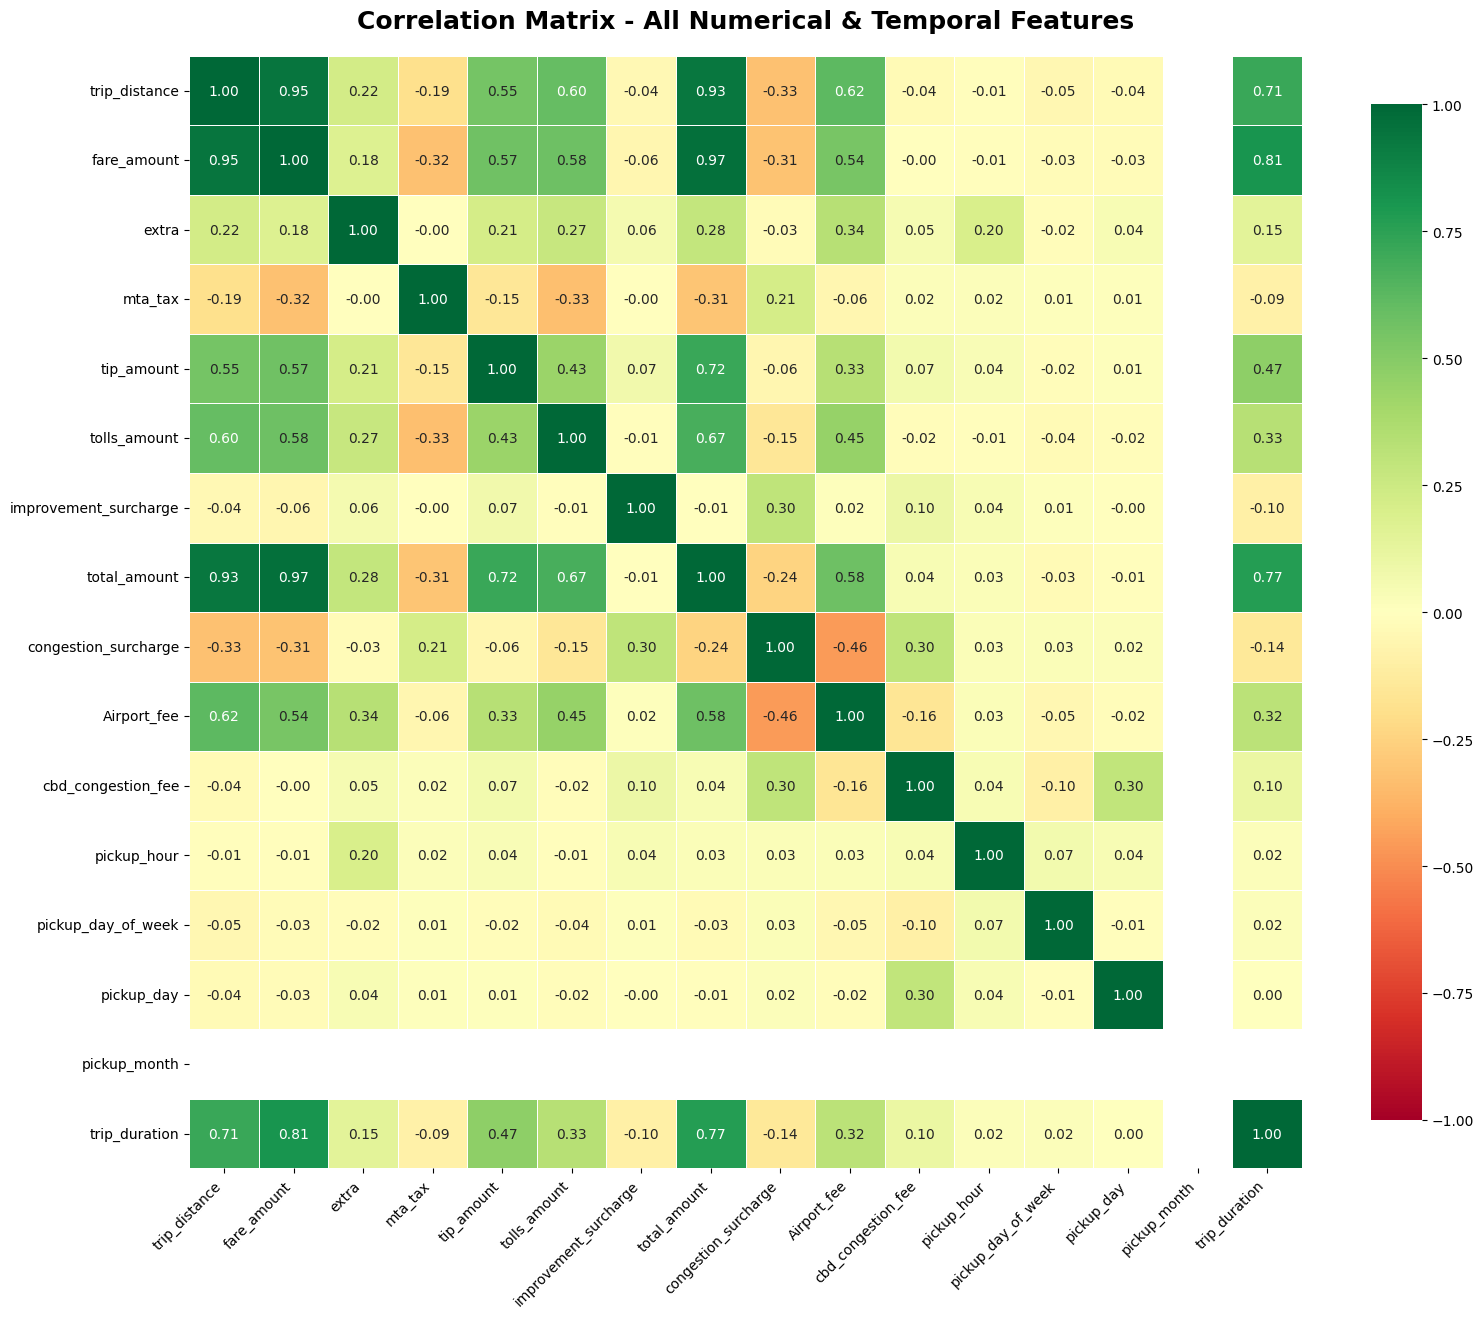


CORRELATIONS WITH TRIP_DURATION (sorted)
fare_amount                   :  0.809
total_amount                  :  0.770
trip_distance                 :  0.711
tip_amount                    :  0.471
tolls_amount                  :  0.329
Airport_fee                   :  0.319
extra                         :  0.145
cbd_congestion_fee            :  0.103
pickup_day_of_week            :  0.023
pickup_hour                   :  0.016
pickup_day                    :  0.003
mta_tax                       : -0.087
improvement_surcharge         : -0.098
congestion_surcharge          : -0.145
pickup_month                  :    nan


In [25]:
# Combine numerical and temporal for correlation analysis
correlation_features = numerical_features + temporal_features + [target]

# Calculate correlation matrix
correlation_matrix = df_pandas[correlation_features].corr()

# Create figure
plt.figure(figsize=(16, 14))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix - All Numerical & Temporal Features', 
          fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show top correlations with target
print("\n" + "="*60)
print("CORRELATIONS WITH TRIP_DURATION (sorted)")
print("="*60)
target_corr = correlation_matrix[target].drop(target).sort_values(ascending=False)
for feature, corr_value in target_corr.items():
    print(f"{feature:30s}: {corr_value:6.3f}")

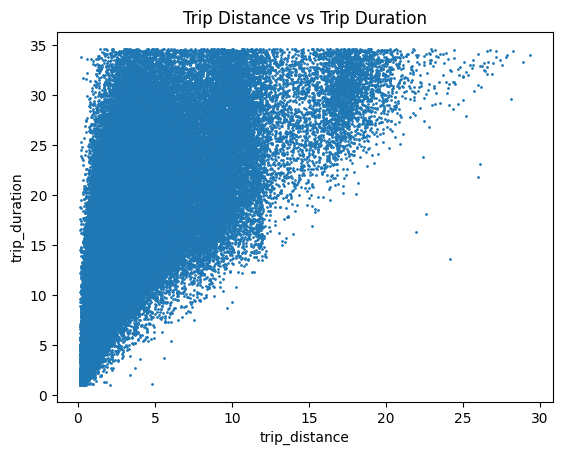

In [26]:
plt.figure()
plt.scatter(df_pandas['trip_distance'], df_pandas[target], s=1)
plt.xlabel('trip_distance')
plt.ylabel('trip_duration')
plt.title('Trip Distance vs Trip Duration')
plt.show()


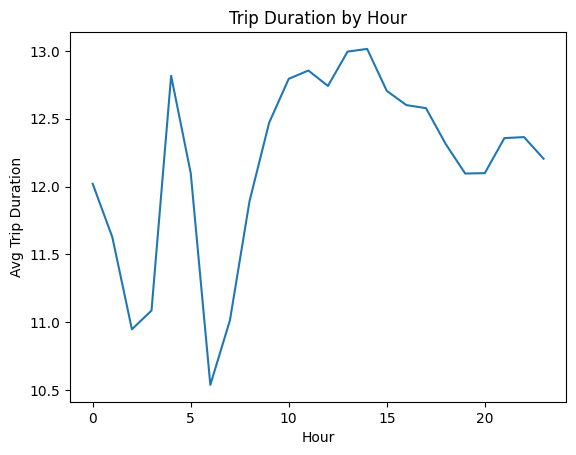

In [27]:
mean_by_hour = df_pandas.groupby('pickup_hour')[target].mean()

plt.figure()
plt.plot(mean_by_hour)
plt.xlabel("Hour")
plt.ylabel("Avg Trip Duration")
plt.title("Trip Duration by Hour")
plt.show()


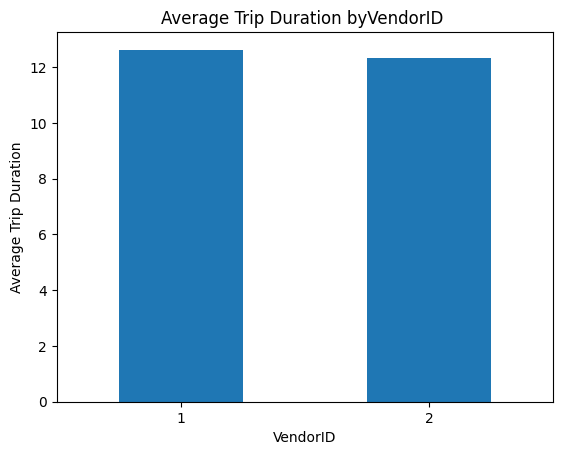

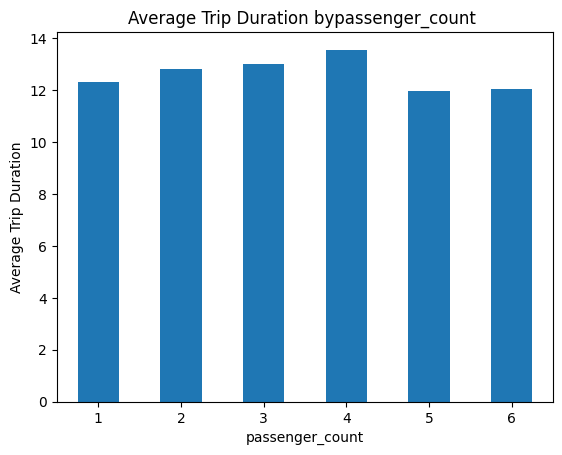

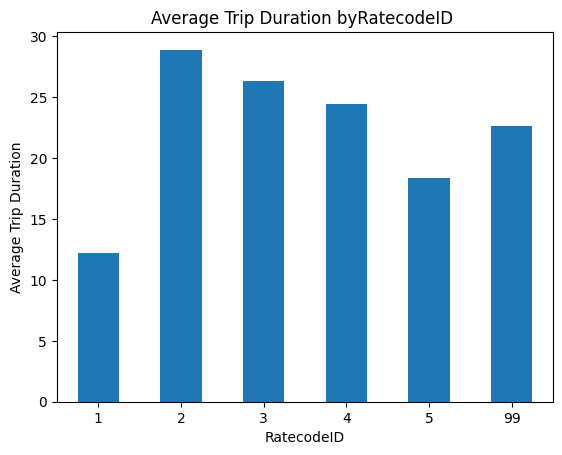

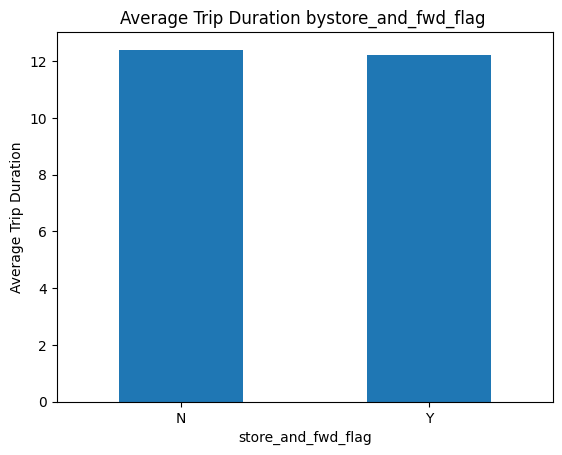

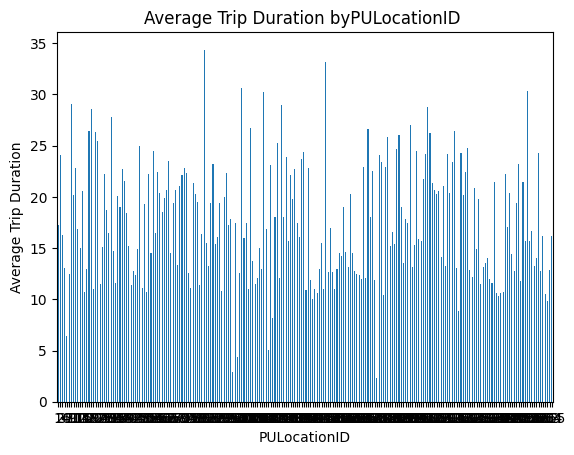

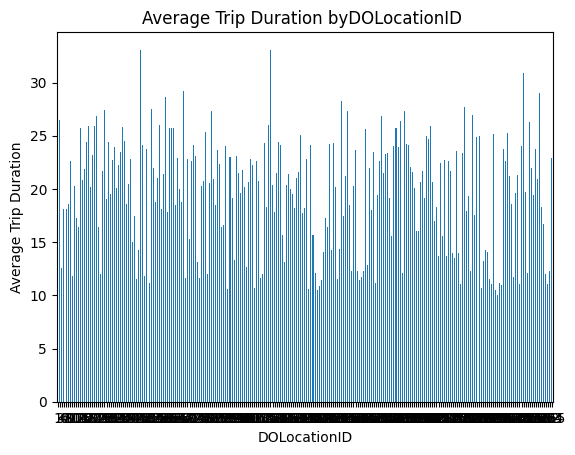

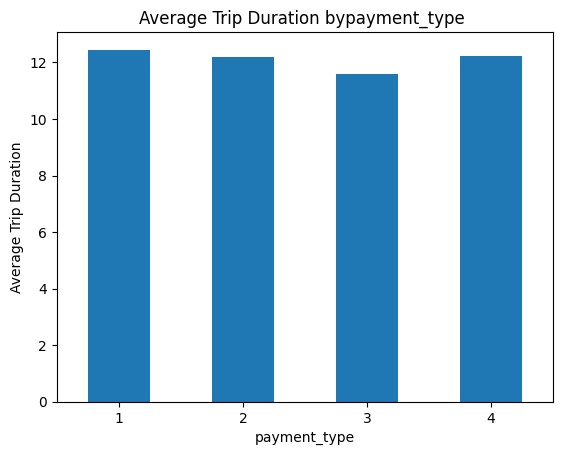

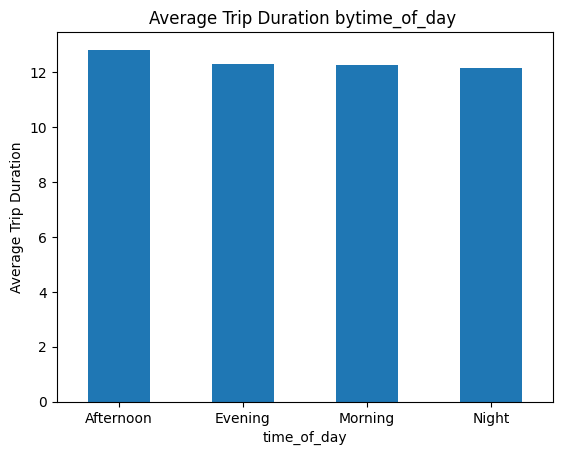

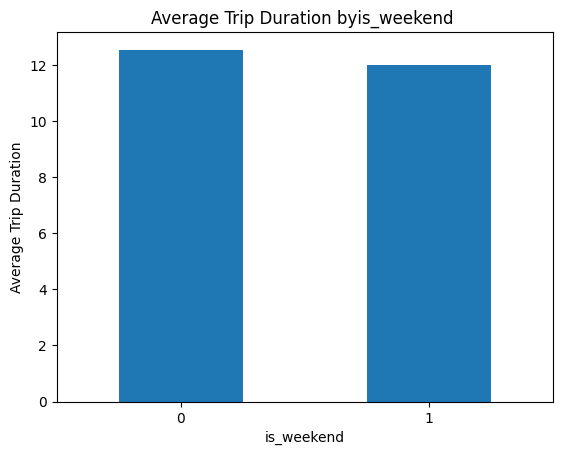

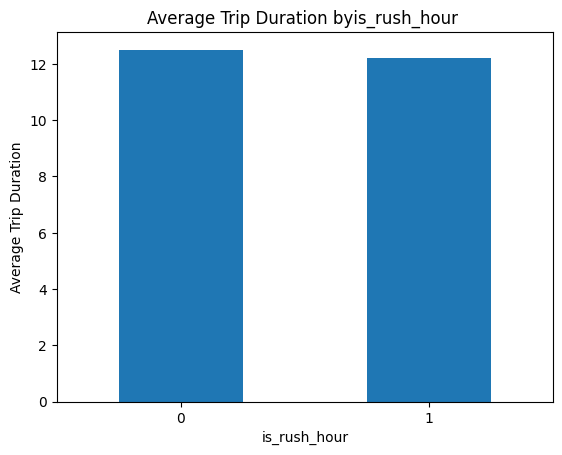

In [28]:
for cat in categorical_features :
    mean_by_rush = df_pandas.groupby(cat)[target].mean()

    plt.figure()
    mean_by_rush.plot(kind='bar')
    plt.xlabel(cat)
    plt.ylabel("Average Trip Duration")
    plt.title(f"Average Trip Duration by{cat} ")
    plt.xticks(rotation=0)
    plt.show()


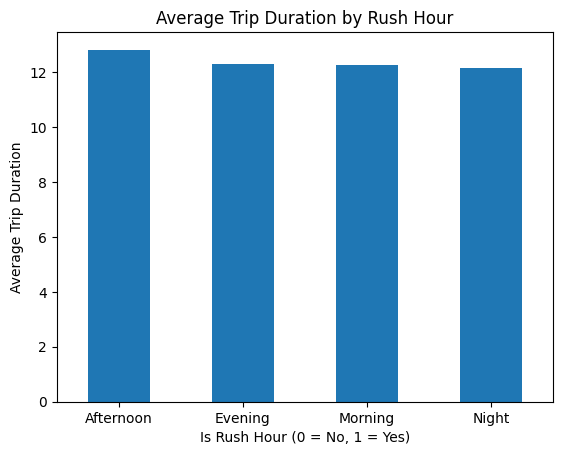

In [29]:
mean_by_rush = df_pandas.groupby('time_of_day')[target].mean()

plt.figure()
mean_by_rush.plot(kind='bar')
plt.xlabel("Is Rush Hour (0 = No, 1 = Yes)")
plt.ylabel("Average Trip Duration")
plt.title("Average Trip Duration by Rush Hour")
plt.xticks(rotation=0)
plt.show()


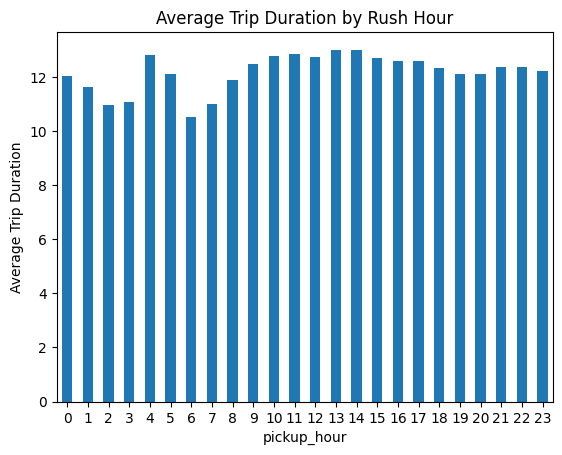

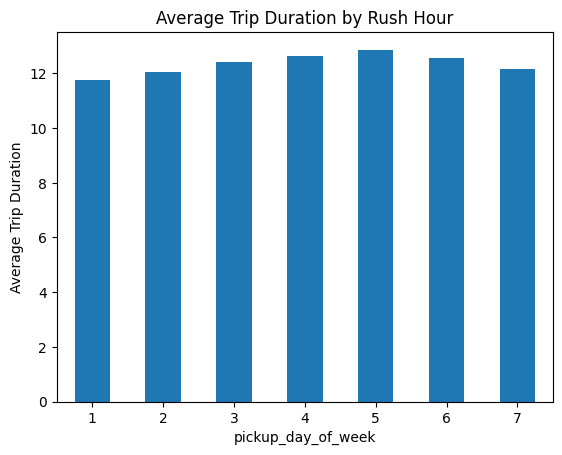

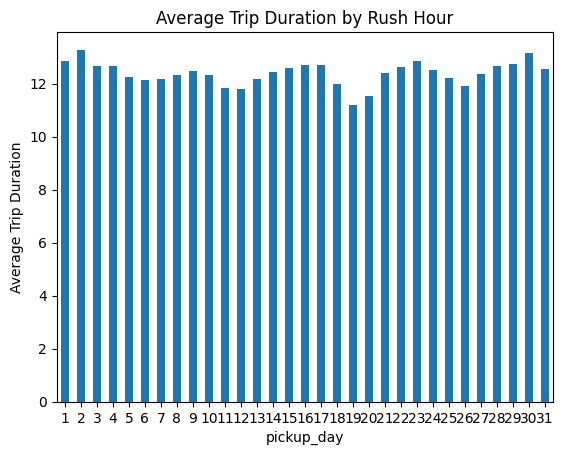

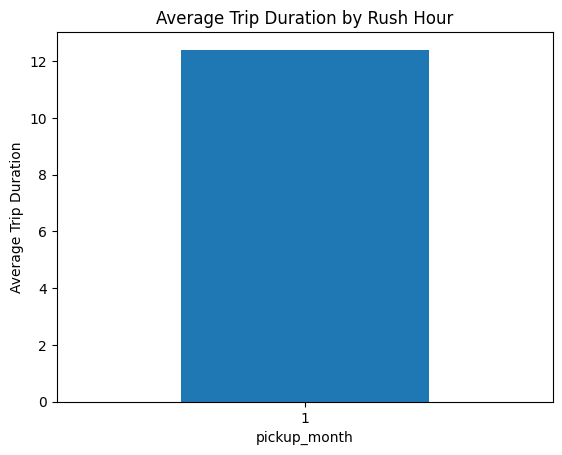

In [30]:
for cat in temporal_features :
    mean_by_rush = df_pandas.groupby(cat)[target].mean()

    plt.figure()
    mean_by_rush.plot(kind='bar')
    plt.xlabel(cat)
    plt.ylabel("Average Trip Duration")
    plt.title("Average Trip Duration by Rush Hour")
    plt.xticks(rotation=0)
    plt.show()


In [31]:
df_silver.columns

['VendorID',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'cbd_congestion_fee',
 'trip_duration',
 'pickup_hour',
 'pickup_day_of_week',
 'pickup_day',
 'pickup_month',
 'time_of_day',
 'is_weekend',
 'is_rush_hour']

# Save silver data in postgresSQL

In [32]:
from pyspark.sql import SparkSession

# PostgreSQL connection details
jdbc_url = "jdbc:postgresql://localhost:5432/silver_data"
connection_properties = {
    "user": "silver_user",
    "password": "silver_pass123",
    "driver": "org.postgresql.Driver"
}

# 🔥 DROP THE OLD TABLE FIRST
print("🗑️ Dropping old table...")
try:
    spark.read.jdbc(url=jdbc_url, table="silver_table", properties=connection_properties)
    # If table exists, drop it
    from py4j.protocol import Py4JJavaError
    
    # Use SQL to drop table
    drop_query = "(SELECT 1) AS tmp"  # Dummy query to get connection
    df_temp = spark.read.jdbc(url=jdbc_url, table=drop_query, properties=connection_properties)
    
    # Better: Use JDBC URL with query
    spark.read.format("jdbc") \
        .option("url", jdbc_url) \
        .option("dbtable", "(SELECT 1 WHERE 1=0) AS dummy") \
        .option("user", connection_properties["user"]) \
        .option("password", connection_properties["password"]) \
        .option("driver", connection_properties["driver"]) \
        .load()
    
    print("⚠️ Table exists - will be dropped by overwrite mode")
except:
    print("ℹ️ Table doesn't exist yet")

# Check your data before saving
print(f"📊 Total rows to save: {df_silver.count():,}")
print(f"📋 Schema:")
df_silver.printSchema()
print(f"📈 Sample data:")
df_silver.show(5)

# Optimize for 2M rows
print("🔄 Optimizing partitions for write...")
df_silver_optimized = df_silver.repartition(20)

# Write to PostgreSQL with overwrite
print("💾 Writing to PostgreSQL... This may take a few minutes for 2M rows...")

df_silver_optimized.write \
    .mode("overwrite") \
    .option("batchsize", "100000") \
    .jdbc(url=jdbc_url, 
          table="silver_table", 
          properties=connection_properties)

print("✅ Data successfully saved to PostgreSQL!")

# Verify the data was saved
print("🔍 Verifying data in PostgreSQL...")
df_verify = spark.read \
    .jdbc(url=jdbc_url, 
          table="silver_table", 
          properties=connection_properties)

print(f"✅ Rows in PostgreSQL: {df_verify.count():,}")
df_verify.show(5)

🗑️ Dropping old table...
⚠️ Table exists - will be dropped by overwrite mode


📊 Total rows to save: 2,630,868
📋 Schema:
root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day_of_week: integer (nullable = true)
 |-- pickup_d

✅ Data successfully saved to PostgreSQL!
🔍 Verifying data in PostgreSQL...


✅ Rows in PostgreSQL: 2,630,868


+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+-----------+------------------+----------+------------+-----------+----------+------------+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|trip_duration|pickup_hour|pickup_day_of_week|pickup_day|pickup_month|time_of_day|is_weekend|is_rush_hour|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+-----------+------------------+-----